In [2]:
from fastai.vision.all import *
from fastai.interpret import *
from fastai.vision.widgets import *
import os
import random

In [3]:
path = os.path.expanduser("~/cg-training-set")
failed = verify_images(get_image_files(path))
failed

(#0) []

In [4]:
training_snapshot=!tree -J {path}
with open("training_snapshot.json", "w") as f:
    f.write("\n".join(training_snapshot))

In [5]:
test_path = os.path.expanduser("~/cg-test-set")
if not os.path.exists(test_path):
    print("Separating test set")
    for label in ['n', 'p']:
        os.makedirs(test_path + "/" + label)
        candidates = get_image_files(path + '/' + label)
        random.shuffle(candidates)
        for i in range(0, 400):
            shutil.move(candidates[i], test_path + "/" + label + "/" + candidates[i].name)

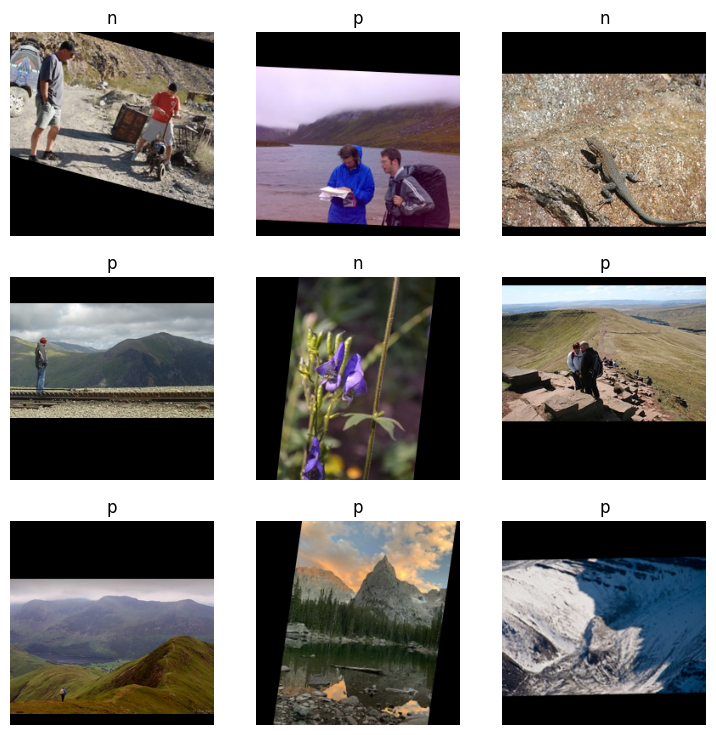

In [6]:
data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[
        Resize(method="pad", pad_mode="zeros", size=240),
    ],
    batch_tfms=[
        Brightness(),
        Rotate(max_deg=15),
    ]
)
dls = data_block.dataloaders(path)
dls.show_batch()

In [7]:
l = vision_learner(dls, resnet34, metrics=[accuracy], lr=3e-3)

SuggestedLRs(valley=0.0014454397605732083)

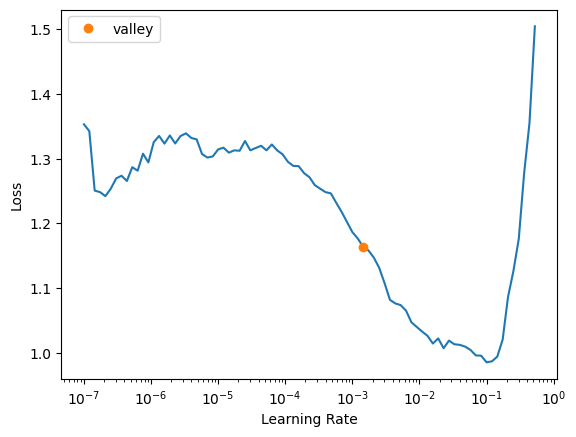

In [8]:
l.lr_find()

In [9]:
_

SuggestedLRs(valley=0.0014454397605732083)

In [ ]:
l.fine_tune(4) # .9147 is the best accuracy after 4 epochs on resnet34

epoch,train_loss,valid_loss,accuracy,time
0,0.701814,0.456523,0.839806,01:19


epoch,train_loss,valid_loss,accuracy,time
0,0.436545,0.342575,0.890430,02:04
1,0.324885,0.312060,0.898058,02:24


In [ ]:
interp = ClassificationInterpretation.from_learner(l)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(50, ncols=5)

In [ ]:
!mkdir -p out
export_fname="model-" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
l.export("./out/"+export_fname)
shutil.copy("./out/"+export_fname, "./out/latest.pkl")
print("Model exported to " + export_fname)

In [ ]:
!aws s3 sync --exclude latest.pkl out s3://contourguessr-models